In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading the dataset

In [2]:
import os
import gzip

In [3]:
def load_fmnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
X_train, y_train = load_fmnist('Weights/fashion/', kind='train')
X_test, y_test = load_fmnist('Weights/fashion/', kind='t10k')

In [5]:
X_train = X_train.copy()
y_train = y_train.copy()
X_test = X_test.copy()
y_test = y_test.copy()

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


# Pruning the dataset

In [7]:
X_train = X_train[np.logical_or(y_train == 1, y_train == 2)]
y_train = y_train[np.logical_or(y_train == 1, y_train == 2)]
X_test = X_test[np.logical_or(y_test == 1, y_test == 2)]
y_test = y_test[np.logical_or(y_test == 1, y_test == 2)]

In [40]:
y_train = y_train - 1
y_test = y_test - 1

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12000, 784), (12000,), (2000, 784), (2000,))

# Binarizing the dataset

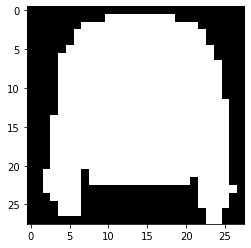

In [42]:
plt.imshow(X_train[1].reshape(28, 28), cmap='gray')

In [43]:
for i in tqdm(range(len(X_train))):
    X_train[i] = X_train[i] > 128
    X_train[i] = X_train[i]*255

100%|██████████| 12000/12000 [00:00<00:00, 101775.29it/s]


In [44]:
for i in tqdm(range(len(X_test))):
    X_test[i] = X_test[i] > 128
    X_test[i] = X_test[i]*255


100%|██████████| 2000/2000 [00:00<00:00, 93249.24it/s]


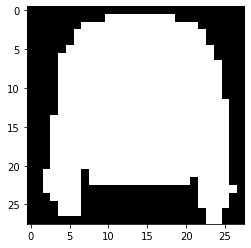

In [45]:
plt.imshow(X_train[1].reshape(28, 28), cmap='gray')

In [46]:
np.unique(y_train)

array([0, 1], dtype=uint8)

In [47]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb.score(X_test, y_test)

0.932

# Calculating prior probabilities and conditional probabilities

In [48]:
def priorProb(y, label):
    totalExamples = y.shape[0]
    classExamples = np.sum(y == label)
    return classExamples/float(totalExamples)

In [96]:
def conditional_prob(X_train, y_train, label, featureName, featureValue):
    X_filtered = X_train[y_train == label]
    # numerator = 0.0
    # denominator = 0.0
    # for i in range(X_train.shape[0]):
    #     if X_train[i][featureName] == featureValue and y_train[i] == label:
    #         numerator += 1
        
    numerator = np.sum(X_filtered[:, featureName] == featureValue)
    denominator = np.sum(y_train == label)
    return (numerator + 1) / (float(denominator) + 2)

In [97]:
def trainModel(X_train, y_train):
    n_features = X_train.shape[1]
    classes = np.unique(y_train)
    n_classes = len(classes)
    classProb = np.zeros(n_classes)
    for label in classes:
        classProb[label] = priorProb(y_train, label)
    featureVals = np.array([0,255])
    n_featureVals = len(featureVals)
    condProb = np.zeros((n_classes, n_features, n_featureVals))
    for label in classes:
        for feature in range(n_features):
            for featureValue in featureVals:
                print(label, feature, featureValue//255)
                condProb[label, feature, featureValue//255] = conditional_prob(X_train, y_train, label, feature, featureValue)
    return classProb, condProb


In [98]:

def predict(X_train, y_train, x_test, condProb, classProb):
    # x_test is a single testing point with n features
    n_features = X_train.shape[1]
    classes = np.unique(y_train)
    posteriorProb = []
    # print(n_features)
    # print(classes)
    # Compute posterior probabilities for each class
    for label in classes:
        likelihood = 1.0
        for feature in range(n_features):
            # print(feature, x_test[feature])
            # conditional_prob = conditionalProb(
                # X_train, y_train, label, feature, x_test[feature])
            conditional_prob = condProb[label, feature, x_test[feature]//255]
            likelihood *= conditional_prob
        # prior_prob = priorProb(y_train, label)
        # prior_prob = 1
        prior_prob = classProb[label]
        prob = likelihood * prior_prob
        posteriorProb.append(prob)
    pred = np.argmax(posteriorProb)
    # print('post', posteriorProb)
    return pred


In [99]:

def score(X_train, y_train, X_test, y_test, condProb, classProb):
    pred = []
    for i in tqdm(range(X_test.shape[0])):
        pred.append(predict(X_train, y_train, X_test[i], condProb, classProb))
    pred = np.array(pred)
    # print('hi')
    # print(pred)
    # print(y_test)
    accuracy = np.sum(pred == y_test) / float(y_test.shape[0])
    return accuracy


In [100]:
classProb, conditionalProb = trainModel(X_train, y_train)

0 0 0
0 0 1
0 1 0
0 1 1
0 2 0
0 2 1
0 3 0
0 3 1
0 4 0
0 4 1
0 5 0
0 5 1
0 6 0
0 6 1
0 7 0
0 7 1
0 8 0
0 8 1
0 9 0
0 9 1
0 10 0
0 10 1
0 11 0
0 11 1
0 12 0
0 12 1
0 13 0
0 13 1
0 14 0
0 14 1
0 15 0
0 15 1
0 16 0
0 16 1
0 17 0
0 17 1
0 18 0
0 18 1
0 19 0
0 19 1
0 20 0
0 20 1
0 21 0
0 21 1
0 22 0
0 22 1
0 23 0
0 23 1
0 24 0
0 24 1
0 25 0
0 25 1
0 26 0
0 26 1
0 27 0
0 27 1
0 28 0
0 28 1
0 29 0
0 29 1
0 30 0
0 30 1
0 31 0
0 31 1
0 32 0
0 32 1
0 33 0
0 33 1
0 34 0
0 34 1
0 35 0
0 35 1
0 36 0
0 36 1
0 37 0
0 37 1
0 38 0
0 38 1
0 39 0
0 39 1
0 40 0
0 40 1
0 41 0
0 41 1
0 42 0
0 42 1
0 43 0
0 43 1
0 44 0
0 44 1
0 45 0
0 45 1
0 46 0
0 46 1
0 47 0
0 47 1
0 48 0
0 48 1
0 49 0
0 49 1
0 50 0
0 50 1
0 51 0
0 51 1
0 52 0
0 52 1
0 53 0
0 53 1
0 54 0
0 54 1
0 55 0
0 55 1
0 56 0
0 56 1
0 57 0
0 57 1
0 58 0
0 58 1
0 59 0
0 59 1
0 60 0
0 60 1
0 61 0
0 61 1
0 62 0
0 62 1
0 63 0
0 63 1
0 64 0
0 64 1
0 65 0
0 65 1
0 66 0
0 66 1
0 67 0
0 67 1
0 68 0
0 68 1
0 69 0
0 69 1
0 70 0
0 70 1
0 71 0
0 71 1
0 72 0
0 72 

In [101]:
print(score(X_train, y_train, X_test, y_test, conditionalProb, classProb))


100%|██████████| 2000/2000 [00:30<00:00, 65.10it/s]

0.9315


In [87]:
print(classProb)

[0.5 0.5]


In [102]:
print(conditionalProb)

[[[9.99833389e-01 1.66611130e-04]
  [9.99833389e-01 1.66611130e-04]
  [9.99833389e-01 1.66611130e-04]
  ...
  [9.99666778e-01 3.33222259e-04]
  [9.99666778e-01 3.33222259e-04]
  [9.99833389e-01 1.66611130e-04]]

 [[9.99833389e-01 1.66611130e-04]
  [9.99833389e-01 1.66611130e-04]
  [9.99833389e-01 1.66611130e-04]
  ...
  [9.87337554e-01 1.26624459e-02]
  [9.98500500e-01 1.49950017e-03]
  [9.99833389e-01 1.66611130e-04]]]


In [89]:
print(conditionalProb[0][100][0])
print(conditionalProb[0][100][1])
print(conditionalProb[1][100][0])
print(conditionalProb[1][100][1])


0.1445
0.8555
0.3345
0.6655


In [22]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [23]:
GaussianNB = GaussianNB()
MultinomialNB = MultinomialNB()
BernoulliNB = BernoulliNB()

In [24]:
GaussianNB.fit(X_train, y_train)
GaussianNB.score(X_test, y_test)

0.935

In [25]:
BernoulliNB.fit(X_train, y_train)
BernoulliNB.score(X_test, y_test)

0.932

In [26]:
MultinomialNB.fit(X_train, y_train)
MultinomialNB.score(X_test, y_test)

0.9625